<a href="https://colab.research.google.com/github/jaleel-muhiyadeen-206/ML-Models/blob/main/CM2604_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importing Drive and Libaries**

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_recall_fscore_support, roc_curve, auc, f1_score
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import warnings

##**Reading the CSV file**

In [44]:
file_path = '/content/drive/MyDrive/CM2604 Assignment/Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

##**Exploratory Data Analysis**

In [45]:
print(df.head()), print(df.shape)
df.info()

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [46]:
df[df['TotalCharges'] == ' '].shape

(11, 21)

In [47]:
# Clean TotalCharges
df['TotalCharges'] = df['TotalCharges'].replace(' ', pd.NA)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Impute missing TotalCharges: reasonable estimate = tenure * MonthlyCharges
df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)

# Verify
df['TotalCharges'].isnull().sum()

/tmp/ipython-input-3869675662.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)


np.int64(0)

In [48]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


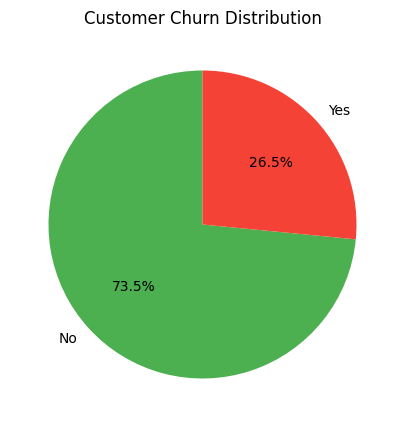

(Churn
 No     5174
 Yes    1869
 Name: count, dtype: int64,
 Churn
 No     73.463013
 Yes    26.536987
 Name: proportion, dtype: float64)

In [49]:
# Churn distribution
churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100
labels = churn_counts.index
sizes = churn_counts.values

fig, ax = plt.subplots(figsize=(5,5))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#F44336'])
ax.set_title('Customer Churn Distribution')
plt.show()

churn_counts, churn_pct

/tmp/ipython-input-1555591997.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=['No', 'Yes'])
/tmp/ipython-input-1555591997.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=['No', 'Yes'])
/tmp/ipython-input-1555591997.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=['No', 'Yes'])


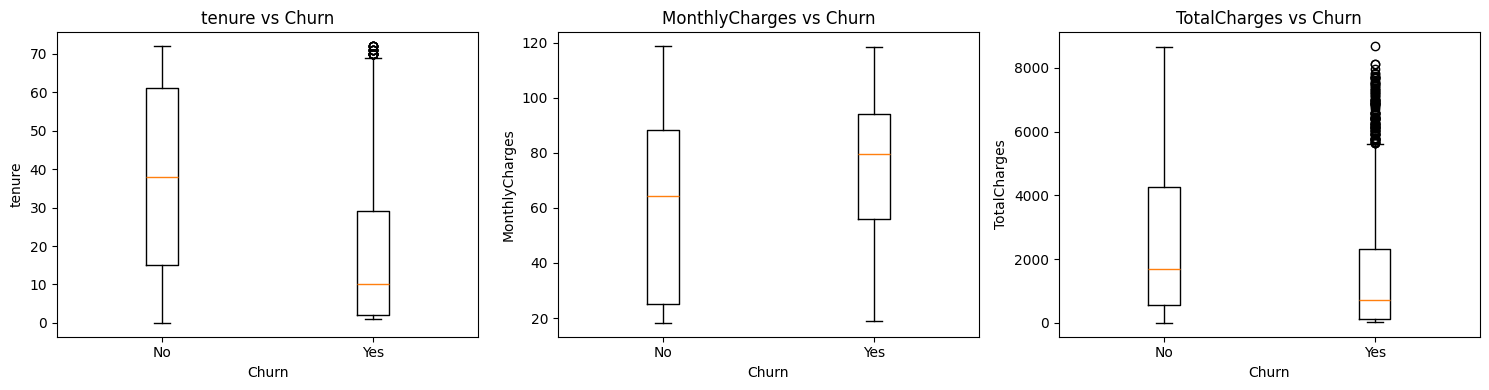

In [50]:
# Numeric features: tenure, MonthlyCharges, TotalCharges
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(numeric_cols):
    # Boxplot: churn vs not
    data = [df[df['Churn'] == 'No'][col], df[df['Churn'] == 'Yes'][col]]
    axes[i].boxplot(data, labels=['No', 'Yes'])
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(col)
    axes[i].set_title(f'{col} vs Churn')

plt.tight_layout()
plt.show()

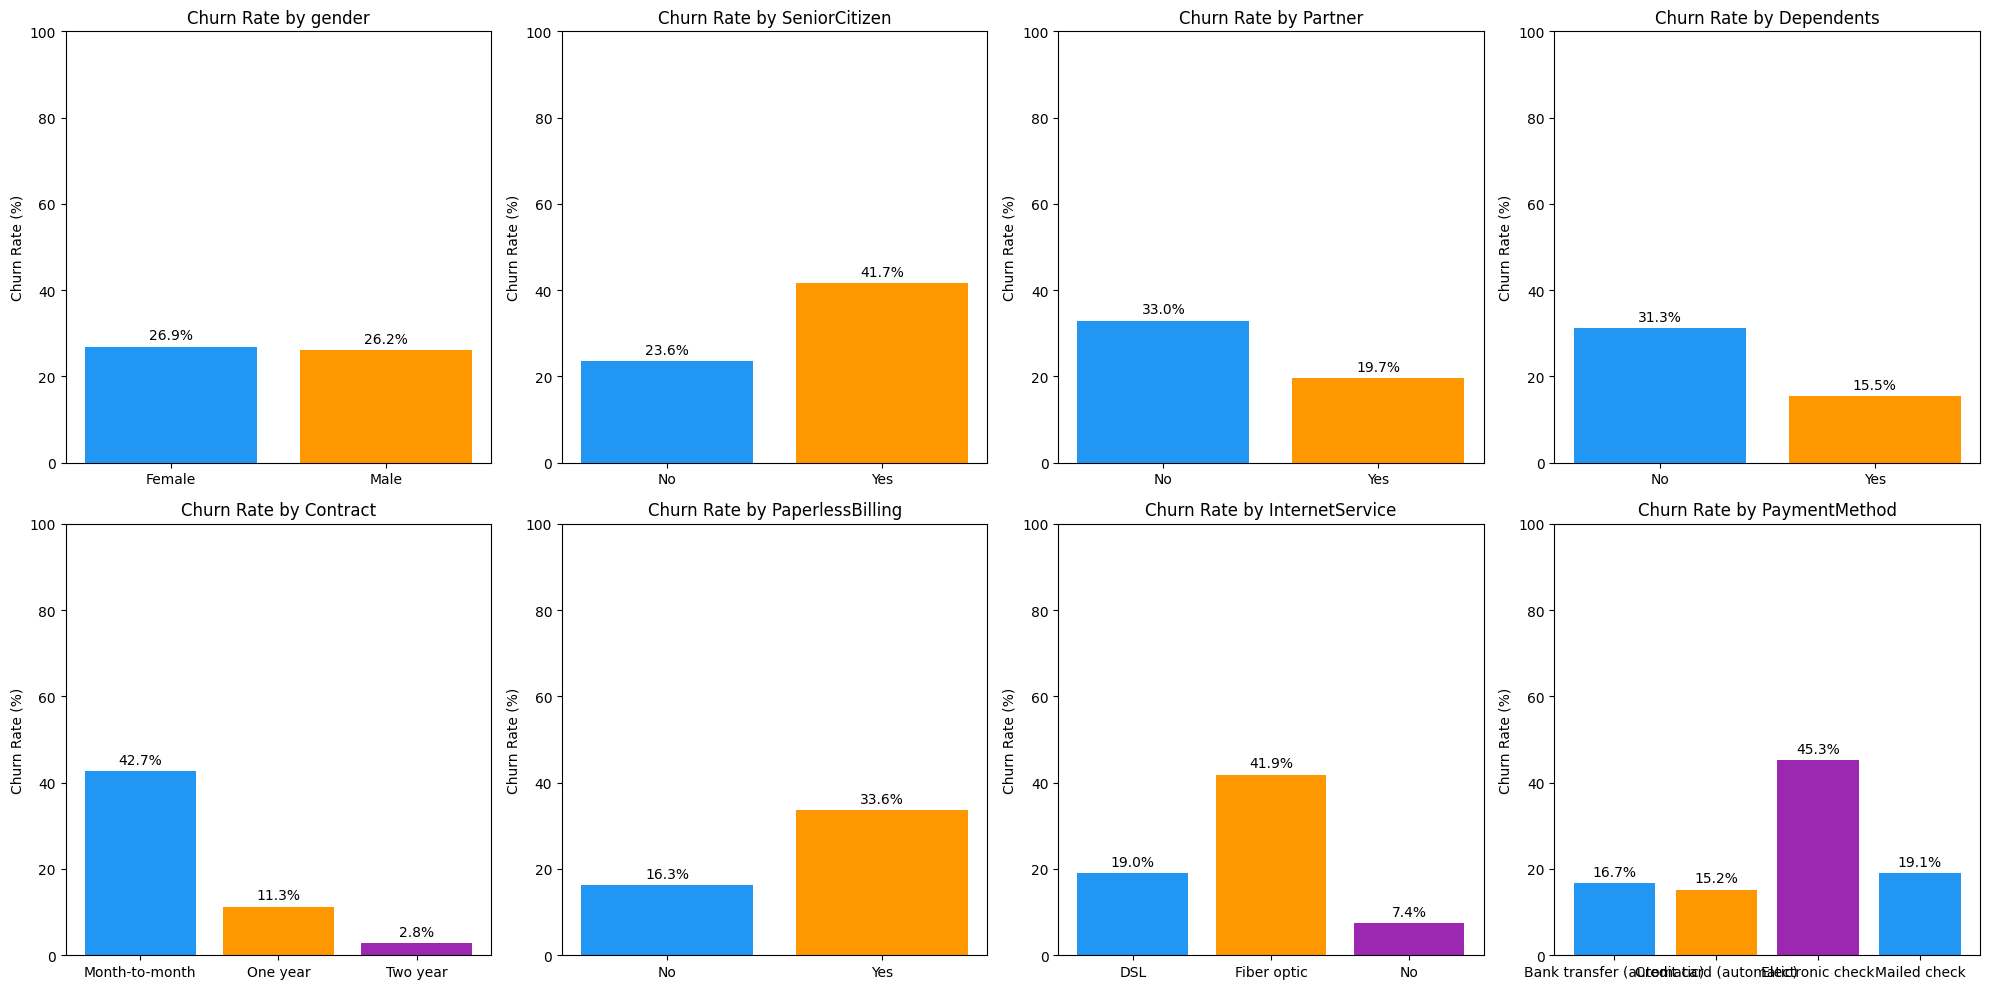

In [51]:
categorical_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'Contract', 'PaperlessBilling', 'InternetService', 'PaymentMethod'
]

# Compute churn rate per category
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col == 'SeniorCitizen':
        # Convert to string for plotting
        temp = df.copy()
        temp['SeniorCitizen'] = temp['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
        col_name = 'SeniorCitizen'
    else:
        temp = df
        col_name = col

    churn_rate = temp.groupby(col_name)['Churn'].apply(lambda x: (x == 'Yes').mean()) * 100
    ax = axes[i]
    bars = ax.bar(churn_rate.index, churn_rate.values, color=['#2196F3', '#FF9800', '#9C27B0'][:len(churn_rate)])
    ax.set_title(f'Churn Rate by {col}')
    ax.set_ylabel('Churn Rate (%)')
    ax.set_ylim(0, 100)
    # Add percentage labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

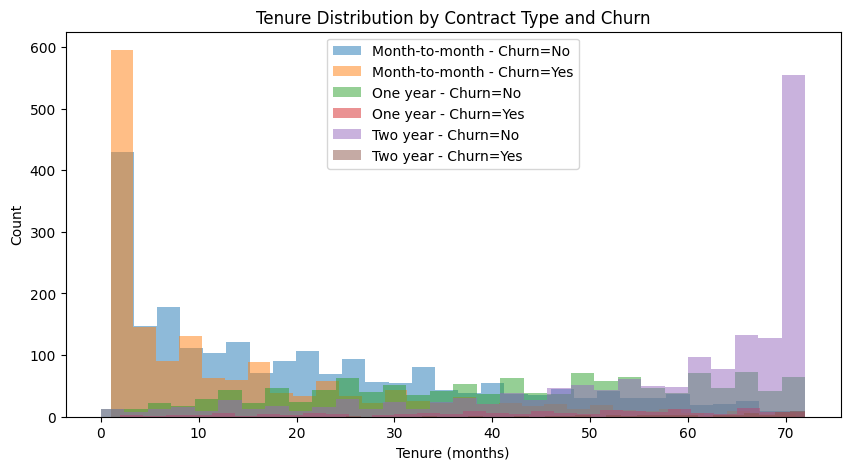

In [52]:
# Tenure histogram by Contract and Churn
fig, ax = plt.subplots(figsize=(10, 5))

for contract in df['Contract'].unique():
    for churn in ['No', 'Yes']:
        subset = df[(df['Contract'] == contract) & (df['Churn'] == churn)]
        ax.hist(subset['tenure'], bins=30, alpha=0.5,
                label=f'{contract} - Churn={churn}',
                density=False)

ax.set_xlabel('Tenure (months)')
ax.set_ylabel('Count')
ax.set_title('Tenure Distribution by Contract Type and Churn')
ax.legend()
plt.show()

In [53]:
# Check for any remaining missing/empty values
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
